<a href="https://colab.research.google.com/github/yespuri/8thlight-react/blob/master/DFDNet_Colab_Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">DFDNet Colab Eng</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [DFDNet](https://github.com/csxmli2016/DFDNet)

Article: [Blind Face Restoration via Deep Multi-scale Component Dictionaries](https://arxiv.org/pdf/2008.00418.pdf)

Creator: **[csxmli2016](https://github.com/csxmli2016).**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).


```
To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```



In [1]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Clone Git repository and install all requirements</font></b>
!pip install dominate

from google.colab import drive
from IPython.display import clear_output
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")
%matplotlib inline

!rm -rf /content/sample_data
!git clone https://github.com/tg-bomze/DFDNet.git

!mkdir /content/DFDNet/checkpoints/
!mkdir /content/DFDNet/checkpoints/facefh_dictionary
!mkdir /content/DFDNet/weights/
!mkdir /content/DFDNet/DictionaryCenter512/

os.chdir('/content/DFDNet/FaceLandmarkDetection/')
!python setup.py install
os.chdir('/content/')
clear_output()
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-18834fa9-d832-52d9-d5bf-aa16dacd1c6a)


In [2]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Save the weights of the pretrained model and mount Google Drive</font></b>
#@markdown **Follow this link:**

#@markdown **https://drive.google.com/drive/folders/1bayYIUMCSGmoFPyd4Uu2Uwn347RW-vl5**

#@markdown **1) right click on 'DFDNet' (top center)**

#@markdown **2) select 'Add shortcut to Drive**

#@markdown ![](https://raw.githubusercontent.com/tg-bomze/DFDNet/whole/shortcut.JPG)

#@markdown *Attention! If the weights have already been saved, then run this block and just mount Google Drive.*

print("Follow the link below, select the account where you saved the pretrained model,")
print("click the 'Allow' button, copy authorization code in the field below and press Enter.")
drive.mount('/content/drive')
clear_output()

In [4]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Copying weights to Colab</font></b>

print("0%/100%   Copying has started and will take about 4 minutes.")
!cp '/content/drive/My Drive/DFDNet/checkpoints/facefh_dictionary/latest_net_G.pth' '/content/DFDNet/checkpoints/facefh_dictionary'
print("33%/100%  Checkpoints copied")
!cp '/content/drive/My Drive/DFDNet/weights/vgg19.pth' '/content/DFDNet/weights/'
print("66%/100%  Weights copied")
!cp -r '/content/drive/My Drive/DFDNet/DictionaryCenter512/' '/content/DFDNet/'
print("100%/100% Dictionary copied")

0%/100%   Copying has started and will take about 4 minutes.
33%/100%  Checkpoints copied
66%/100%  Weights copied
100%/100% Dictionary copied


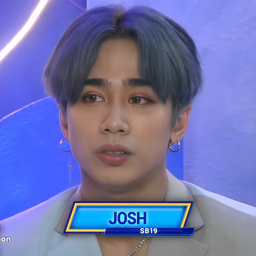

In [5]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Uploading a single face image</font></b>

!rm -rf /content/DFDNet/Results
!rm -rf /content/DFDNet/TestData/TestWhole/*
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one audio at a time!')

cont = uploaded[0]
CONTENT_FILENAME = "content." + cont.split(".")[-1]
os.rename(cont, CONTENT_FILENAME)
content_path = "/content/DFDNet/TestData/TestWhole/" + CONTENT_FILENAME
!mv -f $CONTENT_FILENAME $content_path

pil_content = Image.open(content_path)
(cont_width, cont_height) = pil_content.size
resize_cont = max(cont_width, cont_height)/256

clear_output()
display(pil_content.resize((int(cont_width/resize_cont), int(cont_height/resize_cont))))

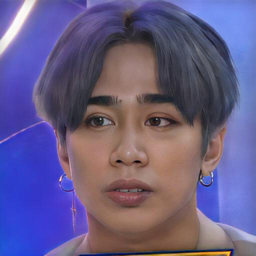

In [6]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Start enchance</font></b>

upscale_factor = 4 #@param {type:"slider", min:1, max:4, step:1}
os.chdir('/content/DFDNet/')
!python test_FaceDict.py --test_path ./TestData/TestWhole --results_dir ./Results/TestWholeResults --upscale_factor $upscale_factor --gpu_ids 0
clear_output()
enchance_face_path = '/content/DFDNet/Results/TestWholeResults/Step3_RestoreCropFace/' + CONTENT_FILENAME
try: 
  pil_result = Image.open(enchance_face_path)
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))
except: pass

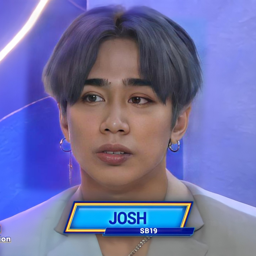

In [7]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Combine with the original image</font></b>

print('\n###############################################################################')
print('############### Step 4: Paste the Restored Face to the Input Image ############')
print('###############################################################################\n')
from data.image_folder import make_dataset
from skimage import io
import numpy as np
import cv2
import dlib

def reverse_align(input_path, face_path, param_path, save_path, upsample_scale=2):
    out_size = (512, 512) 
    input_img = dlib.load_rgb_image(input_path)
    h,w,_ = input_img.shape
    face512 = dlib.load_rgb_image(face_path)
    inv_M = np.loadtxt(param_path)
    inv_crop_img = cv2.warpAffine(face512, inv_M, (w*upsample_scale,h*upsample_scale))
    mask = np.ones((512, 512, 3), dtype=np.float32) #* 255
    inv_mask = cv2.warpAffine(mask, inv_M, (w*upsample_scale,h*upsample_scale))
    upsample_img = cv2.resize(input_img, (w*upsample_scale, h*upsample_scale))
    inv_mask_erosion_removeborder = cv2.erode(inv_mask, np.ones((2 * upsample_scale, 2 * upsample_scale), np.uint8))# to remove the black border
    inv_crop_img_removeborder = inv_mask_erosion_removeborder * inv_crop_img
    total_face_area = np.sum(inv_mask_erosion_removeborder)//3
    w_edge = int(total_face_area ** 0.5) // 20 #compute the fusion edge based on the area of face
    erosion_radius = w_edge * 2
    inv_mask_center = cv2.erode(inv_mask_erosion_removeborder, np.ones((erosion_radius, erosion_radius), np.uint8))
    blur_size = w_edge * 2
    inv_soft_mask = cv2.GaussianBlur(inv_mask_center,(blur_size + 1, blur_size + 1),0)
    merge_img = inv_soft_mask * inv_crop_img_removeborder + (1 - inv_soft_mask) * upsample_img
    io.imsave(save_path, merge_img.astype(np.uint8))

TestImgPath = './TestData/TestWhole'
ResultsDir = './Results/TestWholeResults'
UpScaleWhole = upscale_factor
SaveRestorePath = os.path.join(ResultsDir,'Step3_RestoreCropFace')# Only Face Results
SaveFianlPath = os.path.join(ResultsDir,'Step4_FinalResults')
SaveParamPath = os.path.join(ResultsDir,'Step1_AffineParam') #save the inverse affine parameters
if not os.path.exists(SaveFianlPath):
    os.makedirs(SaveFianlPath)
ImgPaths = make_dataset(SaveRestorePath)
for i,ImgPath in enumerate(ImgPaths):
    ImgName = os.path.split(ImgPath)[-1]
    print('Final Restoring {}'.format(ImgName))
    WholeInputPath = os.path.join(TestImgPath,ImgName)
    FaceResultPath = os.path.join(SaveRestorePath, ImgName)
    ParamPath = os.path.join(SaveParamPath, ImgName+'.npy')
    SaveWholePath = os.path.join(SaveFianlPath, ImgName)
    reverse_align(WholeInputPath, FaceResultPath, ParamPath, SaveWholePath, UpScaleWhole)

clear_output()
enchance_img_path = '/content/DFDNet/Results/TestWholeResults/Step4_FinalResults/' + CONTENT_FILENAME
try: 
  pil_result = Image.open(enchance_img_path)
  (res_width, res_height) = pil_result.size
  resize_res = max(res_width, res_height)/256
  display(pil_result.resize((int(res_width/resize_res), int(res_height/resize_res))))
except: pass

In [8]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Downloading the final result</font></b>
try: files.download(enchance_img_path)
except: files.download(enchance_face_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>